CocaCola sales seem to follow a cycle of four quarters (using quarterly data). We model the sales below.

In the linear model of seasonality:

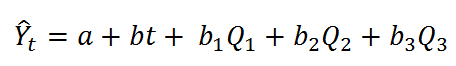

the coefficients of the dummy variables b1, b2 and b3 indicate how much each quarter differs from the reference quarter, quarter4.
The average increase from one quarter to the next is b (the coefficient of t). This is the trend effect.  Quarter 1 averages b1 units higher than the reference quarter, quarter 4, quarter 2 averages b2 units higher than quarter 4, etc. These other coefficients indicate the effect of seasonality. 


In what follows we are implementing a multiplicative seasonal model of seasonality:


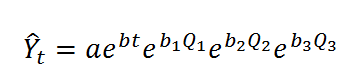

Which after taking logs is:

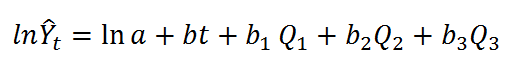

In this multiplicative model the coefficients are percentage changes in the original sales variable Y.  The coefficient of time means that deseasonalized sales increase by b% per quarter. This is the trend effect. The coefficients b1, b2 and b3 mean that the sales in quarters 1, 2 and 3 are respectively b1% above quarter 4, b2% above quarter 4 and b3% above quarter 4. Quarter 4 is the reference quarter.

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
#The following function is borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries pandas series
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Agumented Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [46]:
def detrendPrice(dft):
    #make sure the input dft has no Nan, otherwise OLS will break
    # fit linear model
    series=dft.Sales
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    results = model.fit()
    predictions = results.predict(x_const)
    resid = y - predictions
    df=pd.DataFrame(resid, columns=['Sales'])
    df.index = dft.index
    return df

In [47]:
def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

In [48]:
#The following 2 functions are borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

def plotModelResults(model, X_train, X_test, y_test, plot_intervals=False, test_data=True):
    """
        Plots modelled vs fact values, prediction intervals
    
    """
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    error = MAD_mean_ratio(prediction, y_test)
    if (test_data==True):
        plt.title("Test data MAD_mean_ratio error {0:.2f}%".format(error))
    else:
        plt.title("Train data MAD_mean_ratio error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model,X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [49]:
df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)

In [50]:
df["datetime"]=pd.to_datetime(df['Date']) 

In [51]:
df.set_index('datetime', inplace=True) 

In [52]:
df.drop(["Date"], axis=1, inplace=True)

In [53]:
df.head()

,Sales
datetime,
1986-04-01,1734.83
1986-07-01,2244.96
1986-10-01,2533.80
1987-01-01,2154.96
1987-04-01,1547.82


D:\ANOCONDA3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


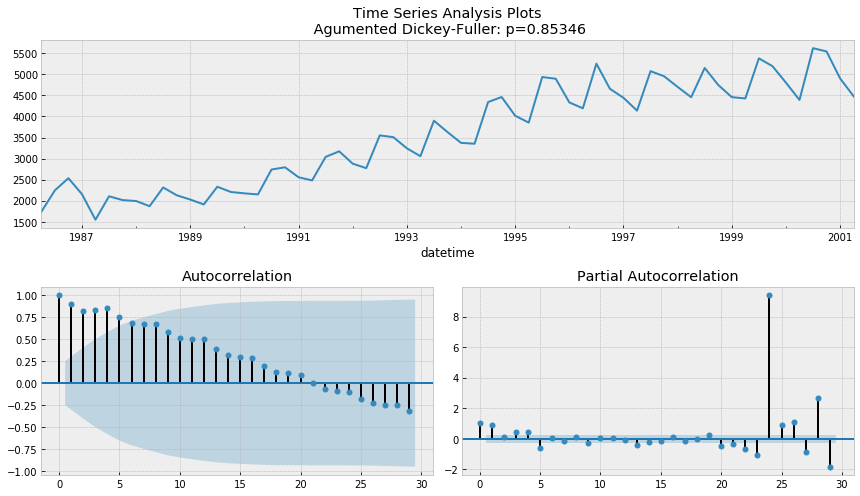

In [54]:
tsplot(df['Sales'],lags = 29)

In [55]:
df.head()

,Sales
datetime,
1986-04-01,1734.83
1986-07-01,2244.96
1986-10-01,2533.80
1987-01-01,2154.96
1987-04-01,1547.82


In [56]:
df.dropna(inplace=True)
df_detrended = detrendPrice(df)

In [57]:
df_detrended

,Sales
datetime,
1986-04-01,67.844791
1986-07-01,514.806090
1986-10-01,740.477390
1987-01-01,298.468689
1987-04-01,-371.840012
...,...
2000-04-01,-813.432447
2000-07-01,353.398852
2000-10-01,212.230151


D:\ANOCONDA3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


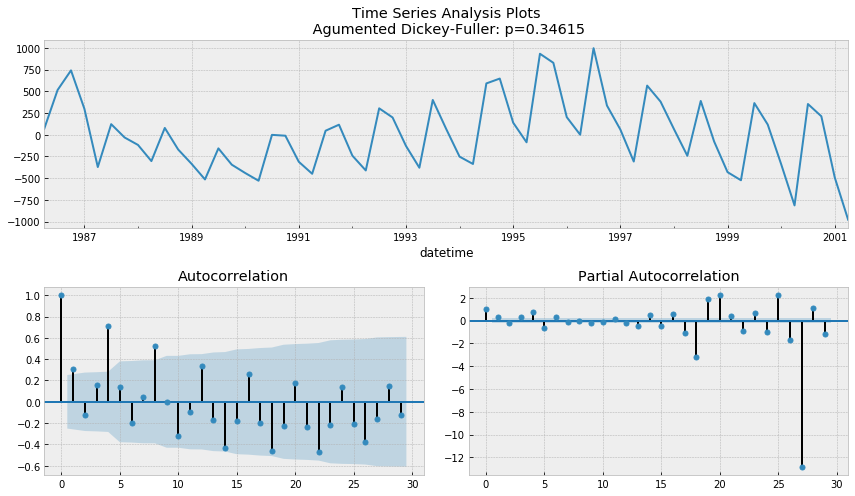

In [58]:
tsplot(df_detrended['Sales'],lags = 29)

In [59]:
df["Sales"] = np.log(df["Sales"])
df["quarter"] = df.index.quarter
df.head()

,Sales,quarter
datetime,,
1986-04-01,7.458665,2
1986-07-01,7.716443,3
1986-10-01,7.837475,4
1987-01-01,7.675527,1
1987-04-01,7.344603,2


In [60]:
df_dummies = pd.get_dummies(df["quarter"], prefix="quarter") 
df_dummies.head()

,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,
1986-04-01,0,1,0,0
1986-07-01,0,0,1,0
1986-10-01,0,0,0,1
1987-01-01,1,0,0,0
1987-04-01,0,1,0,0


In [61]:
df = df.join(df_dummies)
df.head()

,Sales,quarter,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,,,
1986-04-01,7.458665,2,0,1,0,0
1986-07-01,7.716443,3,0,0,1,0
1986-10-01,7.837475,4,0,0,0,1
1987-01-01,7.675527,1,1,0,0,0
1987-04-01,7.344603,2,0,1,0,0


In [62]:
df.drop(["quarter","quarter_4"], inplace=True, axis=1) 
df.head()

,Sales,quarter_1,quarter_2,quarter_3
datetime,,,,
1986-04-01,7.458665,0,1,0
1986-07-01,7.716443,0,0,1
1986-10-01,7.837475,0,0,0
1987-01-01,7.675527,1,0,0
1987-04-01,7.344603,0,1,0


In [63]:
list = []
list = range(0, (df.shape[0]))
df["time"] = list
df.head()

,Sales,quarter_1,quarter_2,quarter_3,time
datetime,,,,,
1986-04-01,7.458665,0,1,0,0
1986-07-01,7.716443,0,0,1,1
1986-10-01,7.837475,0,0,0,2
1987-01-01,7.675527,1,0,0,3
1987-04-01,7.344603,0,1,0,4


In [64]:
y = df["Sales"]
df.drop(["Sales"], inplace=True, axis=1)
x = df

In [74]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(45, 4)
(16, 4)


In [75]:
lr = LinearRegression()

In [76]:
lr_fitted = lr.fit(X_train, y_train)

In [77]:
predictions_train = lr_fitted.predict(X_train)
predictions_test = lr_fitted.predict(X_test)

In [78]:
print(MAD_mean_ratio(y_train, predictions_train))
print(MAD_mean_ratio(y_test, predictions_test))

0.7178592737659402
2.494014005911951


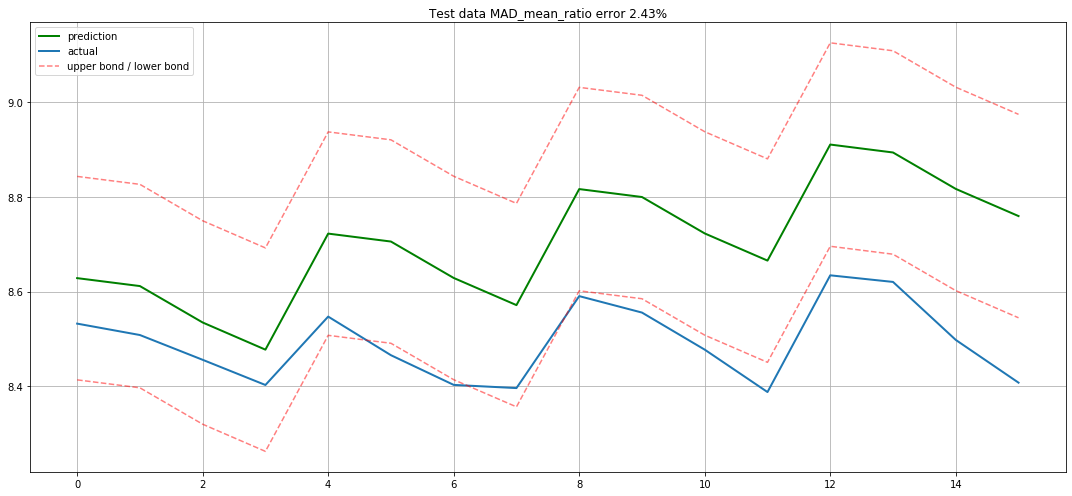

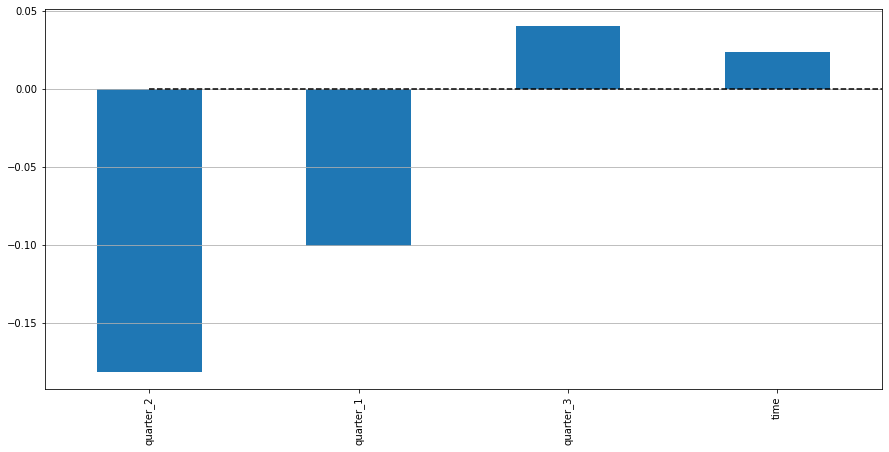

In [80]:
plotModelResults(lr_fitted, X_train=X_train, X_test=X_test, y_test=y_test, plot_intervals=True)
plotCoefficients(lr_fitted,X_train)

In [88]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [87]:
#Load the data with all the features (unscaled)
y = y
X = x
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False, random_state = 42)
       

best alpha:  5
Train set MAD mean ratio score: 0.83
Test set MAD mean ratio score: 1.75


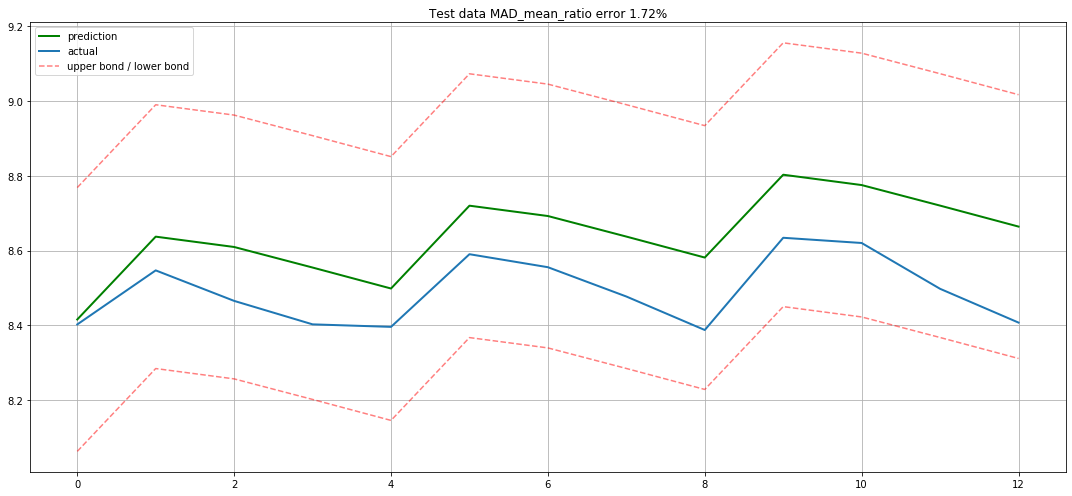

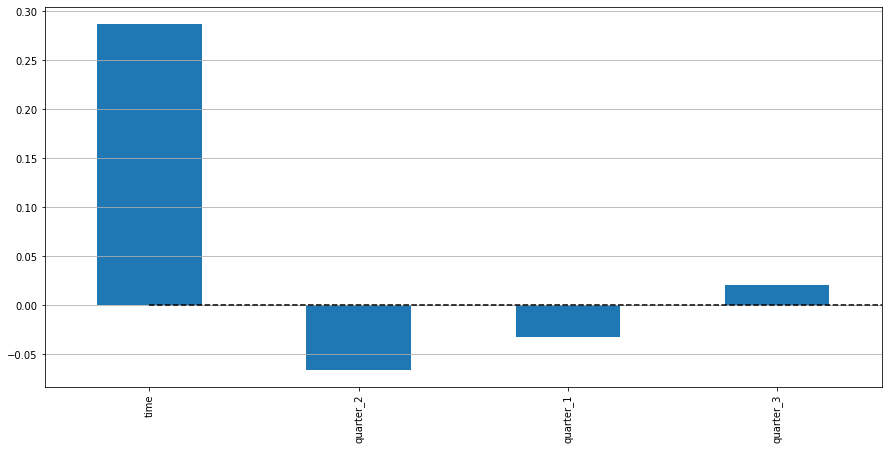

In [90]:
#for setting up the pipeline
ridge = Ridge(max_iter=10000) #don't want any convergence complaints
scaler = StandardScaler()

#this is the pipeline with two steps: scale and fit
pipe = Pipeline([("scaler", scaler), ("ridge", ridge)])

#this is the parameter grid for grid search
param_grid = [{'ridge__alpha':[1000,500,100,50,10,5,1,.5,.1]}]

# for time-series cross-validation set 5 folds for grid search
tscv = TimeSeriesSplit(n_splits=5)

#run grid search to find the best parameters
grid_search_object = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error")
                  
grid_search_object.fit(X_train,y_train)
best_parameters=grid_search_object.best_params_
print("best alpha: ", best_parameters['ridge__alpha'])

#instantiate and fit the best lasso (using the best parameters)
best_ridge = Ridge(alpha=best_parameters['ridge__alpha'])

#do not forget to scale the data
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
best_ridge.fit(X_train_s, y_train)

plotModelResults(best_ridge, X_train=X_train_s, X_test=X_test_s, y_test=y_test, plot_intervals=True)
plotCoefficients(best_ridge,X_train) #X_train is sent in just to get column names
predictions_train = best_ridge.predict(X_train_s)
predictions_test = best_ridge.predict(X_test_s)

train_score = MAD_mean_ratio(y_train, predictions_train)
test_score = MAD_mean_ratio(y_test, predictions_test)

print("Train set MAD mean ratio score: {:.2f}".format(train_score))
print("Test set MAD mean ratio score: {:.2f}".format(test_score))